In [1]:
import numpy as np
import pandas as pd
import scipy.stats as st
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
np.random.seed(42)

df = pd.DataFrame({
    'value': [ 
        1.26,   2.78,   0.63,   0.34,
        3.53,   4.10,   1.31,   0.91,
        11.98,  13.14,  9.86,   6.53,
        90.82,  97.12,  75.85,  59.46,
        83.45,  116.62, 104.00, 80.85,
        55.98,  67.28,  79.33,  82.66,
        66.32,  78.53,  69.10,  67.27,
        37.42,  55.35,  60.76,  73.20
    ], 
    'lambda': [ 
        2,    2,    2,    2,   
        7,    7,    7,    7,    
        12,   12,   12,   12,   
        19.5, 19.5, 19.5, 19.5, 
        29.5, 29.5, 29.5, 29.5, 
        39.5, 39.5, 39.5, 39.5, 
        54.5, 54.5, 54.5, 54.5, 
        75,   75,   75,   75    
    ]
})

xs = [float(i) for i in df['lambda'].unique()]
ys = [np.mean(df[ df['lambda'].values == x_i ].value.values) for x_i in xs]
data = [df[ df['lambda'].values == x_i ].value.values for x_i in xs]

In [ ]:
import confband as cb
# a=10.17, b=153.79, c=17.26, d=-2.58, e=0.455, f=0.01746 
# test = h(xs)
# print(test)

function = lambda x: x[0]**2 + x[1]**2 
print(cb.Hessian(function, [10,10]))

ax = plt.axes(projection='3d')
x = np.linspace(-20, 20, 50)
y = np.linspace(-20, 20, 50)
X, Y = np.meshgrid(x, y)
Z = function([X,Y])
ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap='viridis', edgecolor='none')

In [ ]:
# Random MLE
max = 0
param = []
for i in range(100000):
    a = np.random.uniform(150, 160)
    b = np.random.uniform(15, 20)
    c = np.random.uniform(-5, 0)
    d = np.random.uniform(-2, 2)
    e = np.random.uniform(-2, 2)
    likelyHood = Lik([a, b, c, d, e], ys)
    if likelyHood>max: 
        max=likelyHood
        param = [a,b,c,d,e]
        dvt = Derivative(L, param)
print(max)
print(param)
print(dvt)

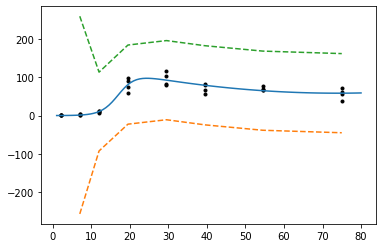

In [2]:
import confband as cb
# Data
plt.plot(xs, data, 'o', color='black', markersize='3')

# Regression
x = np.linspace(1, 80, num=100)
plt.plot(x, cb.eta(x))

# TODO Confidence Bands
h = cb.h(xs, data)
plt.plot(xs, [cb.eta(xs[i]) - h[i] for i in range(len(xs))], linestyle='dashed')
plt.plot(xs, [cb.eta(xs[i]) + h[i] for i in range(len(xs))], linestyle='dashed')